In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

from sklearn.model_selection import train_test_split

import xgboost as xgb

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential

from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error

import warnings
warnings.filterwarnings('ignore')


In [2]:
df=pd.read_csv("SolarPrediction.csv")


In [3]:
df['Data']=df['Data'].apply(lambda x: x.split()[0])

In [4]:
df['Month']=pd.to_datetime(df['Data']).dt.month
df['Day']=pd.to_datetime(df['Data']).dt.day
df['Year']=pd.to_datetime(df['Data']).dt.year
df['Hour']=pd.to_datetime(df['Time']).dt.hour
df['Minute']=pd.to_datetime(df['Time']).dt.minute
df['Second']=pd.to_datetime(df['Time']).dt.second

In [5]:
df['SunriseHour']=df['TimeSunRise'].apply(lambda x: re.search(r'^\d+',x).group(0)).astype(int)
df['SunriseMinute']=df['TimeSunRise'].apply(lambda x: re.search(r':(\d+)',x).group(1)).astype(int)
df['SunsetHour']=df['TimeSunSet'].apply(lambda x: re.search(r':(\d+)',x).group(1)).astype(int)
df['SunsetMinute']=df['TimeSunSet'].apply(lambda x: re.search(r':(\d+)',x).group(1)).astype(int)

In [6]:
df.drop(['UNIXTime','Data','Time','TimeSunRise','TimeSunSet'],axis=1,inplace=True)

In [7]:
df.isnull().sum().sum()

0

In [8]:
input_features=df.drop(['Radiation'],axis=1)
output_features=df['Radiation']

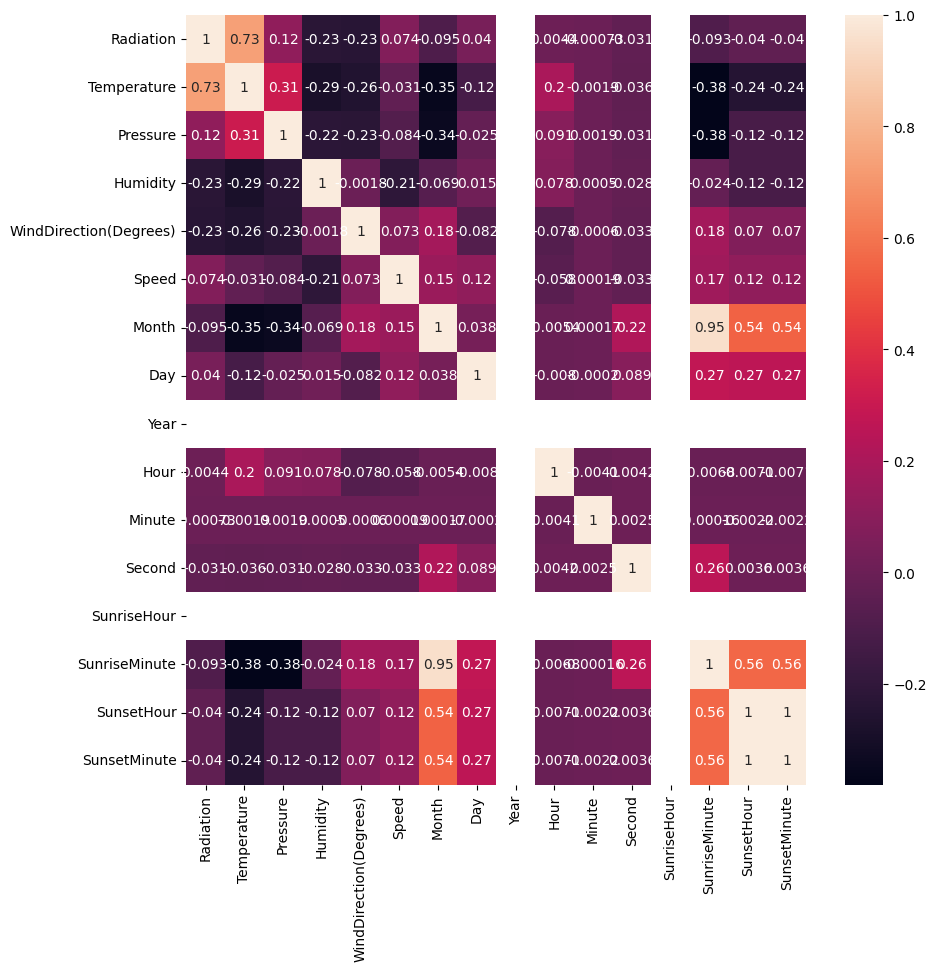

In [9]:
cor=df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(cor,annot=True)
plt.show()

In [10]:
del df

In [11]:
output_features=output_features.apply(lambda x: int(x*100))

In [12]:
scalar=MinMaxScaler()
scaled_input_features=scalar.fit_transform(input_features)
input_features_columns=input_features.columns

In [13]:
feature_selector= SelectKBest(chi2,k='all')
selected_features=feature_selector.fit(scaled_input_features,output_features)

In [14]:
imp=pd.DataFrame(selected_features.scores_,index=input_features_columns,columns=['Importance'])
imp.sort_values(by='Importance',ascending=False, inplace=True)
imp

,Importance
Month,4684.579610
SunriseMinute,4015.062771
WindDirection(Degrees),3271.827277
Day,2841.926850
Minute,2702.449333
Second,2288.673032
SunsetHour,1863.712087
SunsetMinute,1863.712087
Temperature,1651.685632
Humidity,1588.087433


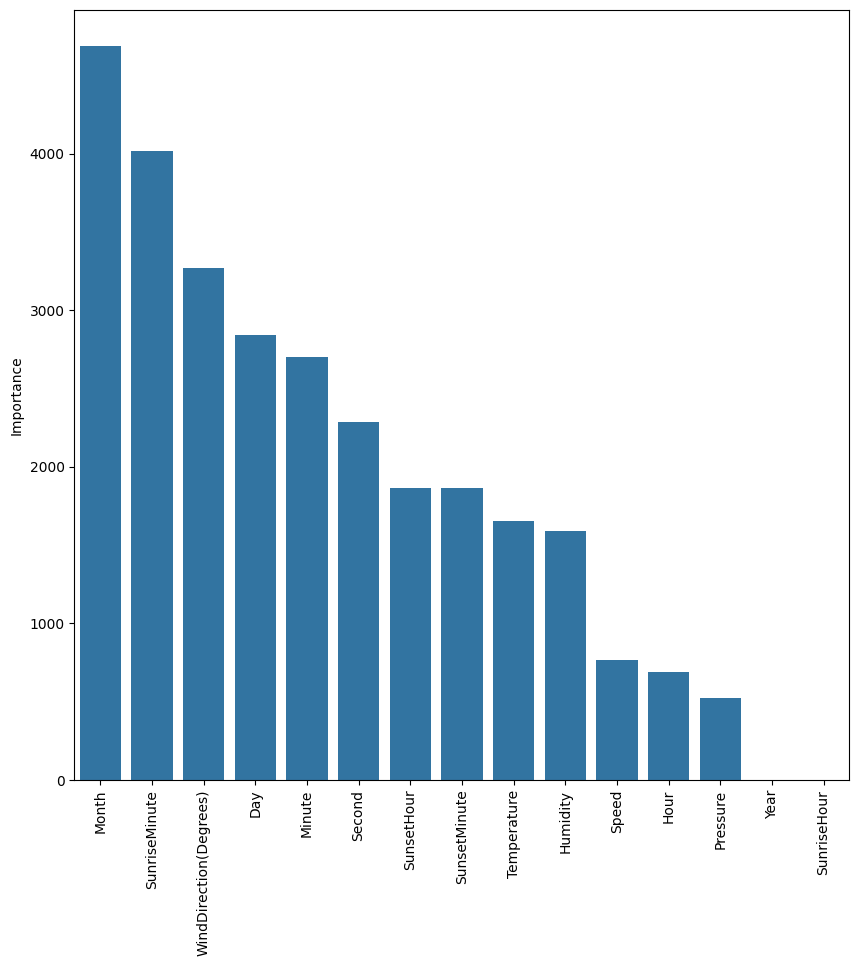

In [15]:
plt.figure(figsize=(10,10))
sns.barplot(imp.Importance)
plt.xticks(rotation=90)
plt.show()

In [16]:
model=ExtraTreesClassifier(n_estimators=20,verbose=2, n_jobs=-1)
model.fit(scaled_input_features,output_features)

building tree 1 of 6
building tree 2 of 6
building tree 3 of 6
building tree 4 of 6
building tree 5 of 6
building tree 6 of 6


ExtraTreesClassifier(n_estimators=6, verbose=2)

In [17]:
imp=pd.DataFrame(model.feature_importances_,index=input_features_columns,columns=['Importance'])
imp.sort_values(by='Importance',ascending=False,inplace=True)
imp

,Importance
WindDirection(Degrees),0.160276
Minute,0.152117
Speed,0.126570
Second,0.125915
Humidity,0.109380
Hour,0.089453
Temperature,0.081950
Pressure,0.074155
Day,0.027429
SunriseMinute,0.017623


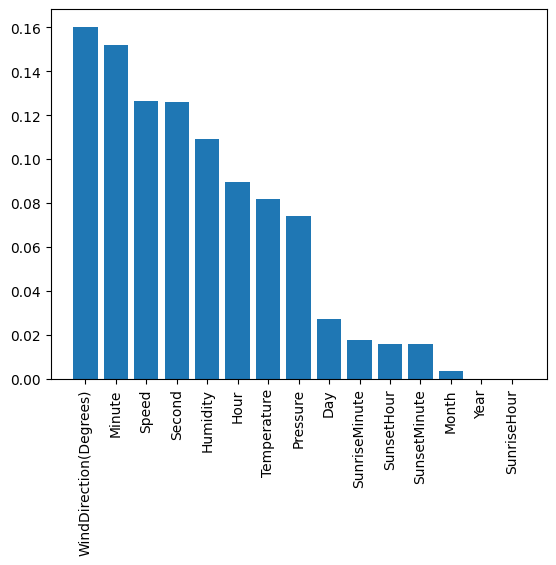

In [18]:
plt.bar(imp.index,imp['Importance'])
plt.xticks(rotation=90)
plt.show()

In [19]:
#feature Engineering

In [42]:
input_features.drop(['Year','SunriseHour'],axis=1)
pd.DataFrame(input_features)


,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Year,Hour,Minute,Second,SunriseHour,SunriseMinute,SunsetHour,SunsetMinute,Temperture
0,48,1.245832e+297,1139.358153,0.492692,1.890095,9,29,2016,23,55,26,6,13,13,13,3.891820
1,48,1.245832e+297,1104.046486,0.490996,1.474763,9,29,2016,23,50,23,6,13,13,13,3.891820
2,48,1.245832e+297,1069.253069,0.440894,1.474763,9,29,2016,23,45,26,6,13,13,13,3.891820
3,48,1.245832e+297,1175.186958,0.382426,1.474763,9,29,2016,23,40,21,6,13,13,13,3.891820
4,48,1.245832e+297,1248.391644,0.291391,1.890095,9,29,2016,23,35,24,6,13,13,13,3.891820
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32681,44,1.029521e+297,3134.681143,0.403851,2.047693,12,1,2016,0,20,4,6,41,42,42,3.806662
32682,44,9.660719e+296,3134.681143,0.327044,2.047693,12,1,2016,0,15,1,6,41,42,42,3.806662
32683,44,9.660719e+296,3134.681143,0.403212,2.302585,12,1,2016,0,10,1,6,41,42,42,3.806662
32684,44,9.660719e+296,3077.931532,0.456011,2.182675,12,1,2016,0,5,2,6,41,42,42,3.806662


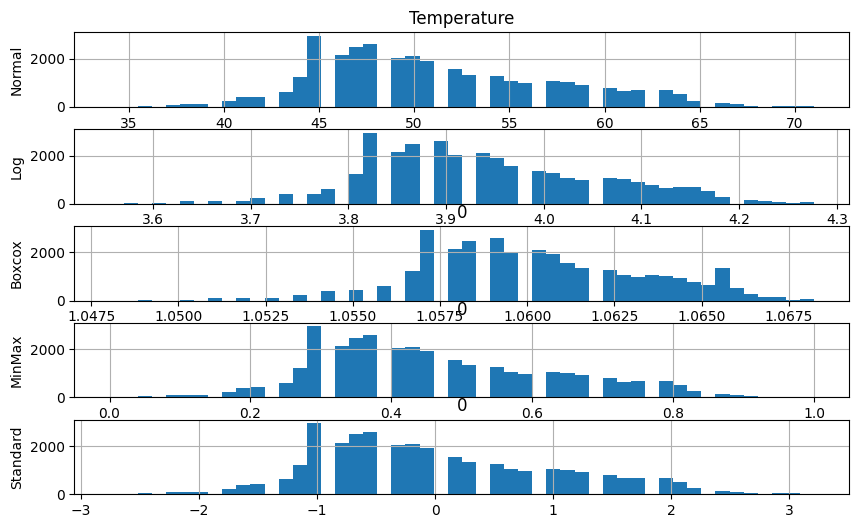

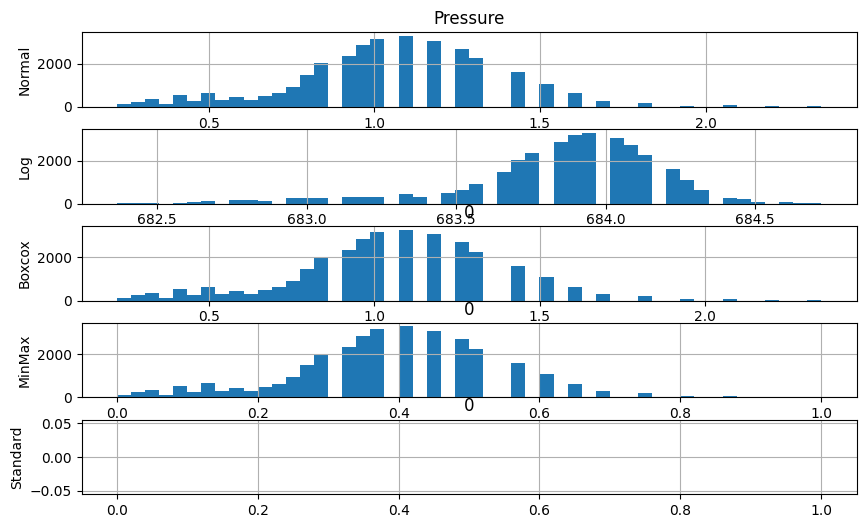

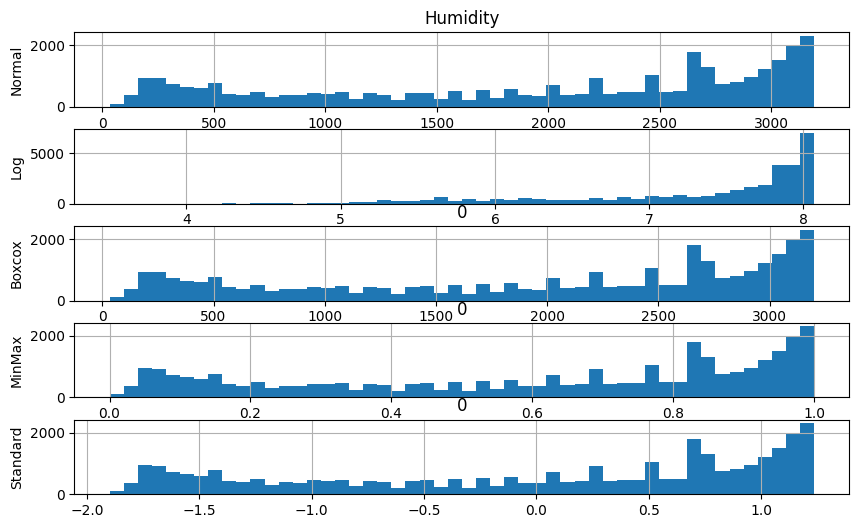

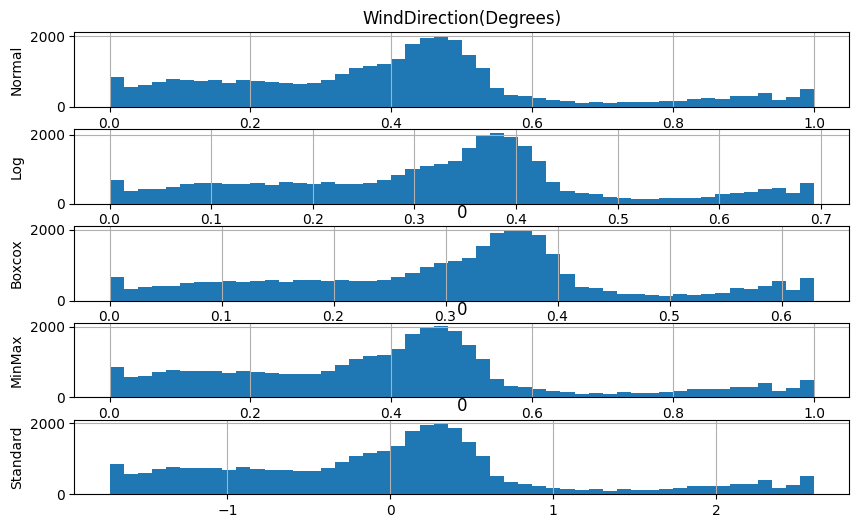

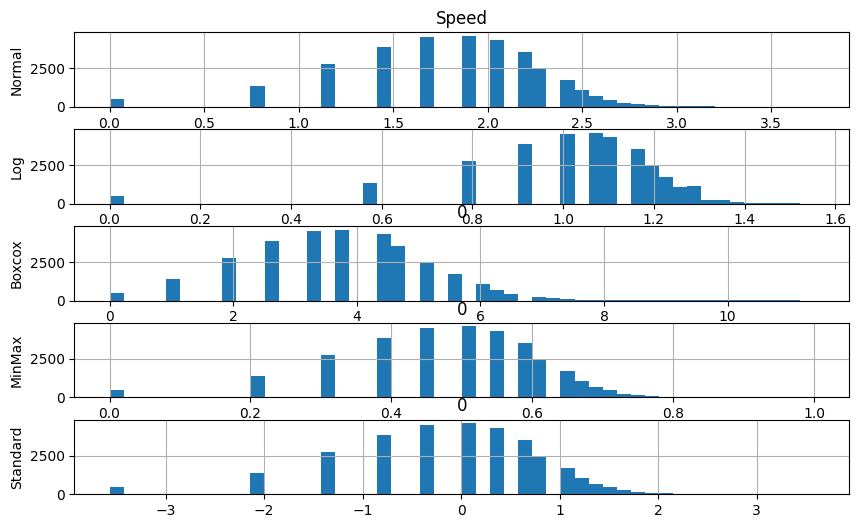

In [43]:
transform_features=['Temperature','Pressure','Humidity','WindDirection(Degrees)','Speed']
for i in transform_features:
    fig, (ax1,ax2,ax3,ax4,ax5)= plt.subplots(5,1, figsize=(10,6))
    input_features[i].hist(ax=ax1, bins=50)
    ((input_features[i]+1).transform(np.log)).hist(ax=ax2, bins=50)
    pd.DataFrame(stats.boxcox(input_features[i]+1)[0]).hist(ax=ax3, bins=50)
    pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame(input_features[i]))).hist(ax=ax4, bins=50)    
    pd.DataFrame(StandardScaler().fit_transform(pd.DataFrame(input_features[i]))).hist(ax=ax5, bins=50)    
    ax1.set_ylabel('Normal')
    ax2.set_ylabel('Log')
    ax3.set_ylabel('Boxcox')
    ax4.set_ylabel('MinMax')
    ax5.set_ylabel('Standard')
    ax1.set_title(i)

In [44]:
transform={'Temperture':(input_features["Temperature"]+1).transform(np.log),
           'Speed': (input_features['Speed']+1).transform(np.log),
           'WindDirection(Degrees)': MinMaxScaler().fit_transform(pd.DataFrame(input_features['WindDirection(Degrees)'])),
           'Pressure': stats.boxcox(input_features['Pressure']+1)[0],
           'Humidity': stats.boxcox(input_features['Humidity']+1)[0]}
           

In [45]:
for i in transform:
    input_features[i]=transform[i]

In [46]:
xTrain, xTest, yTrain, yTest=train_test_split(input_features,output_features, test_size=0.3)

In [65]:
pd.DataFrame(xTrain)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.634675,NaN,1.002809,-1.306906,-2.159372,-0.489167,-1.464625,0.0,-0.221245,1.292604,0.501007,0.0,-0.885871,-1.796111,-1.796111,0.681472
1,-1.464208,NaN,-0.136887,1.409170,1.709729,1.334400,-0.088857,0.0,-0.655745,0.425737,-1.263341,0.0,1.431069,0.537522,0.537522,-1.577493
2,-0.656945,NaN,-1.670156,0.327308,0.592280,0.422616,-1.120683,0.0,-1.524747,-0.441129,-1.109919,0.0,-0.113557,0.537522,0.537522,-0.636790
3,-0.818398,NaN,-0.665166,0.272300,-0.157314,0.422616,-0.318152,0.0,-1.235080,-1.596952,-1.033209,0.0,0.143880,0.411379,0.411379,-0.816834
4,0.473222,NaN,0.786083,-0.832642,-0.157314,-0.489167,1.630854,0.0,0.213256,-0.441129,0.040743,0.0,-0.306636,0.726735,0.726735,0.527382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22875,-0.818398,NaN,0.786083,0.772274,-0.157314,1.334400,0.255085,0.0,1.371925,-1.307996,-0.035968,0.0,1.495429,0.600593,0.600593,-0.816834
22876,0.311770,NaN,0.278235,-0.570039,-0.566696,-0.489167,0.713675,0.0,0.502923,0.136782,-0.035968,0.0,-0.499714,1.042091,1.042091,0.370464
22877,-0.334040,NaN,1.058195,0.055736,-2.159372,-1.400951,0.484380,0.0,1.661592,-1.019040,-0.803076,0.0,-1.078949,-1.039257,-1.039257,-0.287690
22878,0.311770,NaN,0.230138,0.264886,-0.157314,-1.400951,0.828322,0.0,-1.524747,-1.019040,0.040743,0.0,-1.014589,-1.228470,-1.228470,0.370464


In [48]:
scaler=StandardScaler()
xTrain=scaler.fit_transform(xTrain)
xTest=scaler.transform(xTest)

#XGBoost

In [49]:
from xgboost import XGBRegressor

model=XGBRegressor(learning_rate=0.1,max_depth=8)
model.fit(xTrain,yTrain)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [50]:
y_pred=model.predict(xTest)

In [51]:
rmse=np.sqrt(mean_squared_error(yTest,y_pred))
r2=r2_score(yTest,y_pred)

print(f"rmse : {rmse:.2f}")
print(f"r2 : {r2:.2f}")

rmse : 8399.60
r2 : 0.93


#Multilayer Perceptron Model

In [52]:
yTrain.apply(lambda x: x/100)

15544    504.83
29314     22.64
23070      1.23
21034      1.22
7831     369.47
          ...  
28293      1.22
10102    566.92
2542       1.24
1953       1.23
10729    944.88
Name: Radiation, Length: 22880, dtype: float64

In [53]:

yTest.apply(lambda x: x/100)

2006        1.21
5013      337.30
14207       1.25
29766       6.69
1123        1.21
          ...   
7258      669.48
31218      62.75
11679       1.21
148      1017.57
18368     369.68
Name: Radiation, Length: 9806, dtype: float64

In [54]:
model=Sequential([
    Dense(123,activation='relu',input_dim=16),
    Dropout(0.33),
    Dense(64,activation='relu'),
    Dropout(0.33),
    Dense(32,activation='relu'),
    Dropout(0.33),
    Dense(1)
])
    


In [55]:
model.compile(optimizer='adam',loss='mse',metrics=['mse'])

In [56]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 123)                 │           2,091 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 123)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           7,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,140 (47.42 KB)

 Trainable params: 12,140 (47.42 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
history=model.fit(xTrain,yTrain,validation_split=0.1,epochs=20,batch_size=32)

Epoch 1/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 4/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 5/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 6/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 7/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 8/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 9/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 10/20
644/644 ━━━━━━━━━━━━━━━━━━━━ 1s 1m

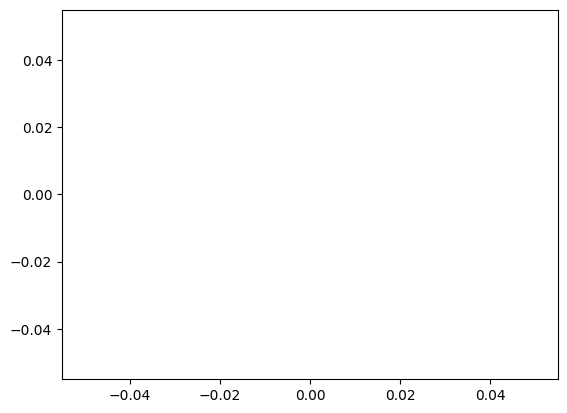

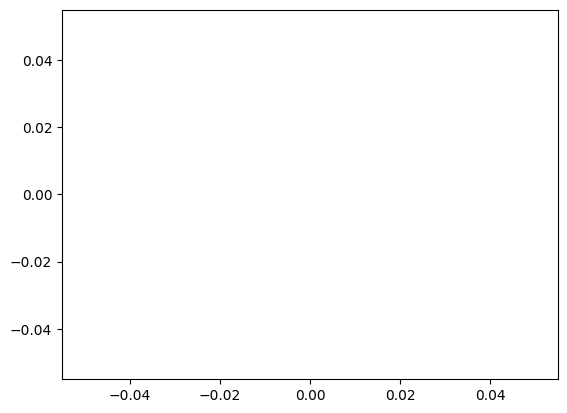

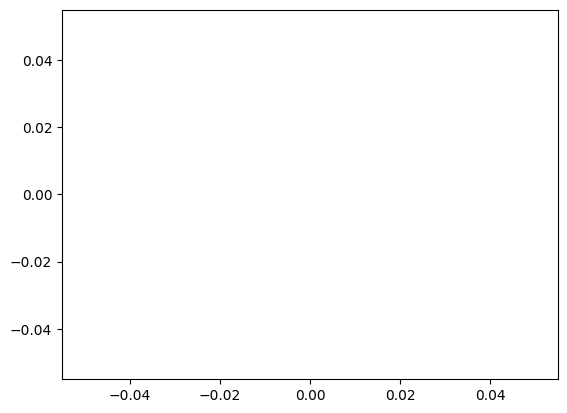

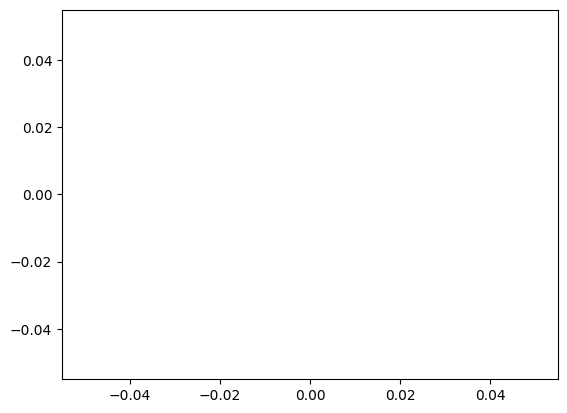

In [58]:
fit=history.history
for i in fit:
    plt.plot(fit[i])
    plt.show()